In [1]:
# Allow reload of objects
%load_ext autoreload
%autoreload
from pelenet.utils import Utils
from pelenet.experiments.readout import ReadoutExperiment

# Official modules
import numpy as np
import nxsdk.api.n2a as nx
import matplotlib
import matplotlib.pyplot as plt
import os
from time import time

In [2]:
# Initilizes the experiment and utils
utils = Utils.instance()
exp = ReadoutExperiment()

In [3]:
# Build network
exp.build()

# Get spectral radius
utils.getSpectralRadius(exp.net.initialWeights)

/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


1.292

In [4]:
# Compile network
compiler = nx.N2Compiler()
board = compiler.compile(exp.net.nxNet)

In [5]:
from nxsdk.graph.processes.phase_enums import Phase

snipDir = os.path.abspath(os.path.join('pelenet', 'snips'))

# Initialize reset SNIP for LMT1 (reset injection)
reset_init = board.createSnip(
    name='init',
    cFilePath=snipDir + "/reset_init.c",
    includeDir=snipDir,
    funcName='initialize_reset',
    phase=Phase.EMBEDDED_INIT,
    lmtId=0,
    chipId=0)
"""
reset_init2 = board.createSnip(
    name='init2',
    cFilePath=snipDir + "/reset_init.c",
    includeDir=snipDir,
    funcName='initialize_reset',
    phase=Phase.EMBEDDED_INIT,
    lmtId=0,
    chipId=1)
"""
# Reset SNIP

board.createSnip(
    name='reset',
    cFilePath=snipDir + "/reset.c",
    includeDir=snipDir,
    guardName='do_reset',
    funcName='reset',
    phase=Phase.EMBEDDED_MGMT, #'mgmt',
    lmtId=0,
    chipId=0)
"""
board.createSnip(
    name='reset2',
    cFilePath=snipDir + "/reset.c",
    includeDir=snipDir,
    guardName='do_reset',
    funcName='reset',
    phase=Phase.EMBEDDED_MGMT, #'mgmt',
    lmtId=0,
    chipId=1)
"""

'\nboard.createSnip(\n    name=\'reset2\',\n    cFilePath=snipDir + "/reset.c",\n    includeDir=snipDir,\n    guardName=\'do_reset\',\n    funcName=\'reset\',\n    phase=Phase.EMBEDDED_MGMT, #\'mgmt\',\n    lmtId=0,\n    chipId=1)\n'

In [6]:
# Create channel for init data with buffer size of 3
initResetChannel = board.createChannel(bytes('initreset', 'utf-8'), "int", 3)
#initResetChannel2 = board.createChannel(bytes('initreset', 'utf-8'), "int", 3)
# Connect channel to init snip
initResetChannel.connect(None, reset_init)
# Start board
board.start()
# Write data to channel
initResetChannel.write(3, [exp.p.numCoresPerChip, exp.p.totalTrialSteps, 1])  # number of cores per chip, reset interval, activate snip (0/1)
#initResetChannel2.write(3, [exp.p.numCoresPerChip, exp.p.trialSteps-1, 1])

#initResetChannel.connect(None, reset_init2)
#initResetChannel.write(3, [exp.p.numCoresPerChip, exp.p.trialSteps-1, 1])

INFO:DRV:  Connecting to 127.0.0.1:42201
INFO:DRV:      Host server up..............Done 0.04s
Compiling in directory : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1579175297.623088
Include dir is : /home/seq/04-anisotropic/v0.x/pelenet/snips -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/
Compiling -c /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1579175297.623088/initnetwork_0_0.c
gcc -Wall -I/home/seq/04-anisotropic/v0.x/pelenet/snips -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /home/seq/.local/share/virtualenvs/seq-r

In [7]:
# Run network
#exp.run()

board.run(exp.p.totalSteps)

#board.finishRun()
board.disconnect()

exp.net.postProcessing()

INFO:DRV:      Configuring registers.......Done 3.84s
INFO:DRV:      Transferring spikes.........Done 6.22ms
INFO:DRV:      Transferring probes.........Done 0.04s
INFO:HST:  chip=0 cpu=0 Transfered values 128, 245, 1 
INFO:DRV:      Executing...................Done 115.53s
INFO:DRV:      Processing timeseries.......Done 4.90s
INFO:DRV:  Executor: 735 timesteps.........Done 124.34s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


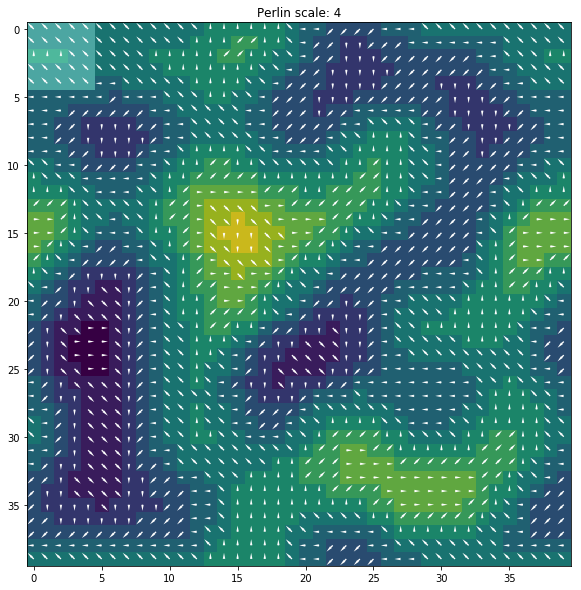

In [8]:
exp.net.plot.landscape()

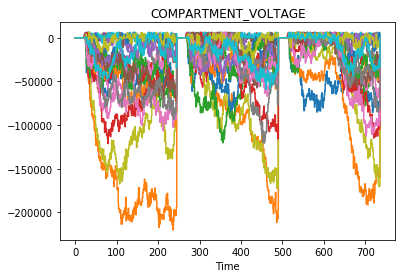

In [9]:
p = exp.net.exVoltageProbes[0].plot()

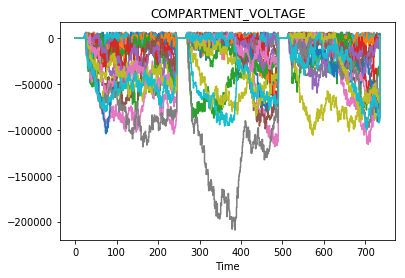

In [10]:
p = exp.net.inVoltageProbes[0].plot()

In [11]:
nev = len(exp.net.exVoltageProbes)
np.sum([exp.net.exVoltageProbes[i].data[:,225] for i in range(nev)])

-42578663

In [12]:
niv = len(exp.net.inVoltageProbes)
np.sum([exp.net.inVoltageProbes[i].data[:,225] for i in range(niv)])

-10219168

In [13]:
nev + niv

100

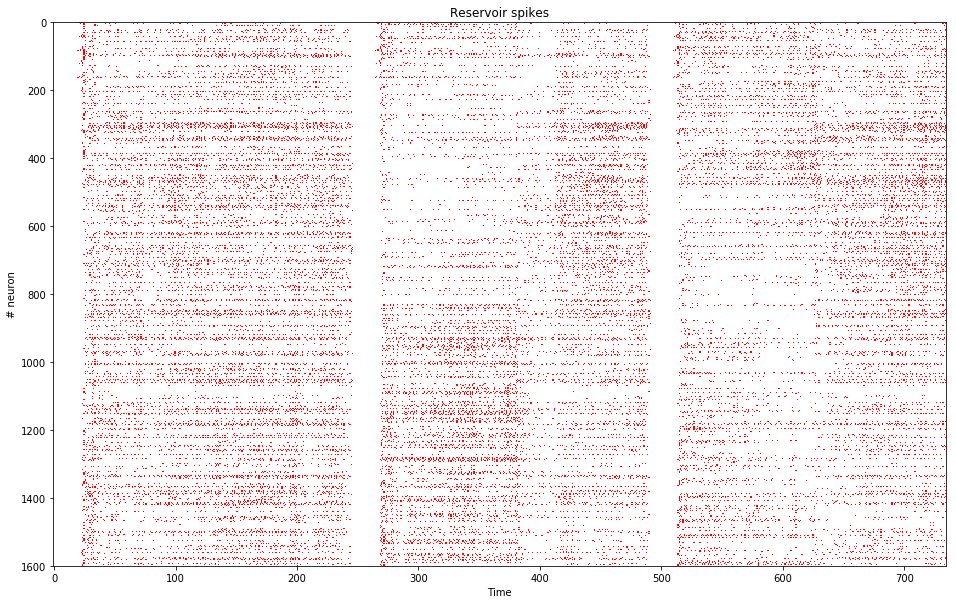

In [14]:
exp.net.plot.reservoirSpikeTrain()

In [15]:
#exp.net.plot.reservoirSpikeTrain(fr=0, to=2500)

In [29]:
print(exp.net.p.trialSteps)
print(exp.net.p.breakSteps)
print(exp.net.p.totalTrialSteps)

225
20
245


In [16]:
exp.net.cueSpikes

[[],
 [20, 23, 265, 268, 510, 513],
 [22, 267, 512],
 [],
 [20, 23, 265, 268, 510, 513],
 [],
 [23, 268, 513],
 [],
 [],
 [22, 267, 512],
 [24, 269, 514],
 [],
 [21, 266, 511],
 [22, 267, 512],
 [],
 [23, 24, 268, 269, 513, 514],
 [],
 [],
 [],
 [20, 21, 265, 266, 510, 511],
 [],
 [21, 266, 511],
 [],
 [],
 [],
 [],
 [23, 268, 513],
 [],
 [22, 267, 512],
 [20, 22, 265, 267, 510, 512],
 [],
 [21, 266, 511],
 [],
 [],
 [],
 [24, 269, 514],
 [],
 [],
 [],
 [],
 [],
 [21, 266, 511],
 [],
 [],
 [24, 269, 514],
 [23, 268, 513],
 [],
 [],
 [],
 [21, 24, 266, 269, 511, 514]]

In [17]:
t1 = exp.net.exSpikeTrains[:,0:75]
t2 = exp.net.exSpikeTrains[:,225:300]
t3 = exp.net.exSpikeTrains[:,450:525]
np.sum(np.abs(t1-t3))

12730

In [18]:
np.sum(exp.net.exSpikeTrains[:,225:230])

756

In [31]:
#print(exp.net.exVoltageProbes[0].data[:,0:20])

In [40]:
#print(exp.net.exSpikeProbes[1].data[:,245:265])

In [38]:
print(exp.net.exVoltageProbes[0].data[:,245:265])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [39]:
print(exp.net.exVoltageProbes[0].data[:,490:510])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [23]:
exp.net.inVoltageProbes[0].data[:,0:75]

array([[     0,      0,      0, ...,    257,  -2048,   3172],
       [     0,      0,      0, ..., -11105, -11586, -11020],
       [     0,      0,      0, ...,  -4163,  -8055,  -3565],
       ...,
       [     0,      0,      0, ..., -64443, -70512, -62973],
       [     0,      0,      0, ..., -43094, -45085, -39811],
       [     0,      0,      0, ..., -80119, -78254, -73409]])

In [24]:
exp.net.inVoltageProbes[0].data[:,225:300]

array([[  -8930,  -12589,   -2758, ...,     256,     257,   -2048],
       [  -1227,    4977,     637, ...,     330,    1337,    1271],
       [ -49792,  -40192,  -37205, ...,  -69423,  -78321,  -79616],
       ...,
       [ -78337,  -79631,  -84958, ..., -101923, -106162, -105074],
       [ -49209,  -49878,  -51538, ...,   -5488,   -8292,  -11983],
       [ -62578,  -65666,  -61435, ...,     256,     257,   -3072]])

In [25]:
# Output spikes
exp.net.outSpikeProbes[0].data[:,20:40]

array([[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0,

In [26]:
p = exp.net.exCurrentProbes[0].plot()

IndexError: list index out of range

In [ ]:
voltageExSums = []
for j in range(400,650):
    voltageSum =  np.sum([ exp.net.exVoltageProbes[i].data[:,j] for i in range(len(exp.net.exVoltageProbes)) ])
    voltageExSums.append(voltageSum)
p = plt.plot(voltageExSums)

In [ ]:
print(voltageExSums[-1])

In [ ]:
p = exp.net.inVoltageProbes[0].plot()

In [ ]:
p = exp.net.inCurrentProbes[0].plot()

In [ ]:
voltageSums = []
for j in range(400,500):
    voltageSum =  np.sum([ exp.net.inVoltageProbes[i].data[:,j] for i in range(len(exp.net.inVoltageProbes)) ])
    voltageSums.append(voltageSum)
p = plt.plot(voltageSums)

In [ ]:
print(voltageSums[-1])

In [ ]:
offset = exp.p.cueSteps + exp.p.cueRelaxation
data = np.array([ exp.net.exSpikeTrains[:,offset+i*exp.p.trialSteps:offset+i*exp.p.trialSteps+exp.p.movementSteps] for i in range(exp.p.trials)])
shp = data.shape
shp

In [ ]:
spikeDiffs = np.zeros((exp.p.trials,exp.p.trials))
for i in range(exp.p.trials):
    for j in range(exp.p.trials):
        spikeDiffs[i,j] = np.sum(np.abs(data[i] - data[j]))/(shp[1]*shp[2])

p = plt.imshow(spikeDiffs)

In [ ]:
# TODO Calculate for every binned vector
err = np.sum(np.abs(data[5] - data[2]), axis=0)/(shp[1])
p = plt.plot(err)

In [ ]:
binSize = 10
(params, ye, performance) = utils.trainOLS(data[:9], data[9], exp.targetFunction, filter='bins', binSize=binSize)

plt.title(performance.cor)
plt.plot(ye)
plt.plot(np.array([np.mean(exp.targetFunction[i:i+binSize]) for i in range(0,len(exp.targetFunction),binSize)]))
p = plt.show()

In [ ]:
exp.net.cueSpikes